In [1]:
#connect to database

import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image




connection = pymysql.connect(
    # host='192.168.208.1',
    host='192.168.11.6',
    user='root', 
    password='water',
    database='waterdata',
    port=30000)


dt = 0.01

try:
    with connection.cursor() as cursor:
               
        sql1 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967137.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "054151-2" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967137.1.1"
                    ''')
        
        
        sql2 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967138.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "054021-1" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967138.1.1" AND `B`.`bl_ahd` > 0
                    ''')
        
        
        
        sql3 = ('''  SELECT 
                        `A`.`read_date`, `A`.`meter_no` AS `bl_meter1`, `A`.`bl_ahd` AS `bl_ahd1`, 
                        `B`.`meter_no` AS `bl_meter2`, `B`.`bl_ahd` AS `bl_ahd2`,
                        `C`.`meter_no` AS `meter_no3`, `C`.`sl_read1` AS `sl_read1`,
                        `D`.`meter_no` AS `meter_no4`, `D`.`rf_read1` AS `rf_read1`
                    FROM   
                        `groundwater` AS `A`  
                    INNER JOIN
                        `groundwater` `B` ON (`B`.`meter_no` = "GW967137.2.2" AND `B`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `surfacewater` `C` ON (`C`.`meter_no` = "419051" AND `C`.`read_date` = `A`.`read_date` )
                    INNER JOIN
                        `rainfall` `D` ON (`D`.`meter_no` = "54151-2" AND `D`.`read_date` = `A`.`read_date` )
                    WHERE  
                        `A`.`meter_no` = "GW967137.1.1" AND `A`.`read_date` <= '2017-11-30'
                    ''')
        
   
    
    df1_orig = pd.read_sql_query(sql1, connection, parse_dates=['read_date','%Y-%m-%d'], coerce_float=True)  ## , index_col="A.read_date"
    df2_orig = pd.read_sql_query(sql2, connection, parse_dates=['read_date','%Y-%m-%d'], coerce_float=True)
    
    

     
  
except:
    print("Error: unable to convert the data")
connection.close()


In [2]:
#filter out incomplete rows from the groundwater series start date
        
df1 = df1_orig[df1_orig['read_date'] >= '2005-11-17']                              # Elfin Crossing Data
df2 = df2_orig[df2_orig['read_date'] >= '2007-09-06']                              # Green Gully Data

# Add moving ave for rainfall
df1['rf_MA90'] = (df1['rf_read1'].rolling(window=90).mean())
df2['rf_MA90'] = (df2['rf_read1'].rolling(window=90).mean())
df1['rf_MA180'] = (df1['rf_read1'].rolling(window=180).mean())
df2['rf_MA180'] = (df2['rf_read1'].rolling(window=180).mean())

# Remove Nan's

df1.dropna(inplace=True)
df2.dropna(inplace=True)

# Add bins for rainfall MA

df1['rf_bin'] = pd.cut(
    df1['rf_MA90'],
    bins=[-1,40,80,120,160],                             
    labels=[1,2,3,4],
    include_lowest=True
    )

df2['rf_bin'] = pd.cut(
    df2['rf_MA90'],
    bins=[-1,40,80,120,160],                             
    labels=[1,2,3,4],
    include_lowest=True
    )


# Skip next cell for summary correllation heatmap

In [3]:
#calculate the bore level change for 1 day, 1 week and 1 month

# setup date deltas

day_0 = (df1['read_date'])

day_1 = (day_0) - pd.DateOffset(days=1)
day_7 = (day_0) - pd.DateOffset(days=7)
day_14 = (day_0) - pd.DateOffset(days=14)
day_30 = (day_0) - pd.DateOffset(days=30)


#Elfin

# correct data types

df1['bl_ahd1'] = pd.to_numeric(df1['bl_ahd1'] )
df1['bl_ahd2'] = pd.to_numeric(df1['bl_ahd2'])
df1['sl_read1'] = pd.to_numeric(df1['sl_read1'])

#calculate change in bore levels for each date delta

# GW967137.1.1
                                
E_bl_ahd1_dt1 = df1['bl_ahd1'].shift(-1) - df1['bl_ahd1']
E_bl_ahd1_dt7 = df1['bl_ahd1'].shift(-7) - df1['bl_ahd1']
E_bl_ahd1_dt14 = df1['bl_ahd1'].shift(-14) - df1['bl_ahd1']
E_bl_ahd1_dt30 = df1['bl_ahd1'].shift(-30) - df1['bl_ahd1']


# GW967137.2.2

E_bl_ahd2_dt1 = df1['bl_ahd2'].shift(-1) - df1['bl_ahd2']
E_bl_ahd2_dt7 = df1['bl_ahd2'].shift(-7) - df1['bl_ahd2']
E_bl_ahd2_dt14 = df1['bl_ahd2'].shift(-14) - df1['bl_ahd2']
E_bl_ahd2_dt30 = df1['bl_ahd2'].shift(-30) - df1['bl_ahd2']


# 419051 - surface water

E_sl_read1_dt1 = df1['sl_read1'].shift(-1) - df1['sl_read1']
E_sl_read1_dt7 = df1['sl_read1'].shift(-7) - df1['sl_read1']
E_sl_read1_dt14 = df1['sl_read1'].shift(-14) - df1['sl_read1']
E_sl_read1_dt30 = df1['sl_read1'].shift(-30) - df1['sl_read1']

#insert deltas into data frames


df1.insert(11, 'bl_ahd1_dt1', E_bl_ahd1_dt1)
df1.insert(12, 'bl_ahd2_dt1', E_bl_ahd2_dt1)
df1.insert(13, 'sl_read1_dt1', E_sl_read1_dt1)
df1.insert(14, 'bl_ahd1_dt7', E_bl_ahd1_dt7)
df1.insert(15, 'bl_ahd2_dt7', E_bl_ahd2_dt7)
df1.insert(16, 'sl_read1_dt7', E_sl_read1_dt7)
df1.insert(17, 'bl_ahd1_dt14', E_bl_ahd1_dt14)
df1.insert(18, 'bl_ahd2_dt14', E_bl_ahd2_dt14)
df1.insert(19, 'sl_read1_dt14', E_sl_read1_dt14)
df1.insert(20, 'bl_ahd1_dt30', E_bl_ahd1_dt30)
df1.insert(21, 'bl_ahd2_dt30', E_bl_ahd2_dt30)
df1.insert(22, 'sl_read1_dt30', E_sl_read1_dt30)




#Green Gully

# correct data types

df2['bl_ahd1'] = pd.to_numeric(df2['bl_ahd1'] )
df2['bl_ahd2'] = pd.to_numeric(df2['bl_ahd2'])


#calculate change in bore levels for each date delta

# GW967138.1.1

GG_bl_ahd1_dt1 = df2['bl_ahd1'].shift(-1) - df2['bl_ahd1']
GG_bl_ahd1_dt7 = df2['bl_ahd1'].shift(-7) - df2['bl_ahd1']
GG_bl_ahd1_dt14 = df2['bl_ahd1'].shift(-14) - df2['bl_ahd1']
GG_bl_ahd1_dt30 = df2['bl_ahd1'].shift(-30) - df2['bl_ahd1']

# GW967138.2.2

GG_bl_ahd2_dt1 = df2['bl_ahd2'].shift(-1) - df2['bl_ahd2']
GG_bl_ahd2_dt7 = df2['bl_ahd2'].shift(-7) - df2['bl_ahd2']
GG_bl_ahd2_dt14 = df2['bl_ahd2'].shift(-14) - df2['bl_ahd2']
GG_bl_ahd2_dt30 = df2['bl_ahd2'].shift(-30) - df2['bl_ahd2']


# 419051 - surface water

GG_sl_read1_dt1 = df2['sl_read1'].shift(-1) - df2['sl_read1']
GG_sl_read1_dt7 = df2['sl_read1'].shift(-7) - df2['sl_read1']
GG_sl_read1_dt14 = df2['sl_read1'].shift(-14) - df2['sl_read1']
GG_sl_read1_dt30 = df2['sl_read1'].shift(-30) - df2['sl_read1']

#insert deltas into data frames


df2.insert(11, 'bl_ahd1_dt1', GG_bl_ahd1_dt1)
df2.insert(12, 'bl_ahd2_dt1', GG_bl_ahd2_dt1)
df2.insert(13, 'sl_read1_dt1', GG_sl_read1_dt1)
df2.insert(14, 'bl_ahd1_dt7', GG_bl_ahd1_dt7)
df2.insert(15, 'bl_ahd2_dt7', GG_bl_ahd2_dt7)
df2.insert(16, 'sl_read1_dt7', GG_sl_read1_dt7)
df2.insert(17, 'bl_ahd1_dt14', GG_bl_ahd1_dt14)
df2.insert(18, 'bl_ahd2_dt14', GG_bl_ahd2_dt14)
df2.insert(19, 'sl_read1_dt14', GG_sl_read1_dt14)
df2.insert(20, 'bl_ahd1_dt30', GG_bl_ahd1_dt30)
df2.insert(21, 'bl_ahd2_dt30', GG_bl_ahd2_dt30)
df2.insert(22, 'sl_read1_dt30', GG_sl_read1_dt30)


t1  = df1['read_date']

a1 = df1['bl_ahd1']
a2 = df1['bl_ahd2']
a3 = df2['bl_ahd1']
a4 = df2['bl_ahd2']
s1 = df1['bl_ahd1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s2 = df1['bl_ahd2_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s3 = df1['sl_read1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)

t2  = df2['read_date']
          
s4 = df2['bl_ahd1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s5 = df2['bl_ahd2_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)
s6 = df2['sl_read1_dt14'].to_numpy(dtype='float', na_value=np.nan,copy=True)



In [4]:
#df1.head()

df1.describe()


,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,rf_MA180,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
count,5750.000000,5750.000000,5750.000000,5750.000000,5750.000000,5750.000000,5749.000000,5749.000000,5749.000000,5743.000000,5743.000000,5743.000000,5736.000000,5736.000000,5736.000000,5720.000000,5720.000000,5720.000000
mean,252.801450,251.363783,0.208639,2.812730,2.805372,2.802700,-0.000040,0.000007,0.000001,-0.000266,0.000066,0.000021,-0.000526,0.000122,0.000046,-0.001042,0.000220,0.000128
std,0.512175,0.490318,0.151503,8.944105,1.664648,1.268382,0.037855,0.013237,0.072969,0.115681,0.036263,0.143475,0.148904,0.046886,0.151920,0.201783,0.069183,0.169484
min,251.081000,249.964000,0.000000,0.000000,0.024444,0.254444,-0.349000,-0.172000,-1.344000,-1.334000,-0.463000,-2.568000,-1.786000,-0.528000,-2.845000,-2.148000,-0.479000,-3.104000
25%,252.531250,251.062000,0.177000,0.000000,1.700000,1.918056,-0.004000,-0.005000,-0.001000,-0.022000,-0.018000,-0.002000,-0.041000,-0.026000,-0.003000,-0.077000,-0.045000,-0.005000
50%,252.983000,251.439000,0.191000,0.000000,2.411111,2.563333,-0.002000,-0.001000,0.000000,-0.008000,-0.004000,0.000000,-0.012000,-0.006000,0.000000,-0.020000,-0.008000,0.000000
75%,253.111000,251.688000,0.208000,0.200000,3.697778,3.587639,0.000000,0.004000,0.000000,0.004000,0.011000,0.001000,0.009000,0.018000,0.001000,0.024000,0.028000,0.002000
max,255.702000,252.584000,3.413000,149.000000,11.575556,7.751111,1.976000,0.514000,2.068000,2.394000,0.731000,3.099000,2.355000,0.743000,3.083000,2.200000,0.777000,2.999000


In [5]:
df2.describe()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,rf_MA180,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5.153000e+03,5152.000000,5152.000000,5152.000000,5146.000000,5146.000000,5146.000000,5139.000000,5139.000000,5139.000000,5123.000000,5123.000000,5123.000000
mean,281.962293,279.680068,0.215745,1.643023,1.647054e+00,1.646744e+00,0.000447,0.000450,0.000013,0.003312,0.003139,0.000137,0.006972,0.006239,0.000331,0.016096,0.013127,0.000783
std,1.507877,1.053038,0.160166,7.335049,1.931273e+00,1.718100e+00,0.109414,0.044506,0.076846,0.330112,0.059176,0.151479,0.446244,0.082517,0.160217,0.612811,0.147662,0.179347
min,279.481000,276.879000,0.000000,0.000000,2.763222e-16,2.032942e-15,-0.510000,-2.190000,-1.344000,-1.790000,-2.175000,-2.568000,-2.220000,-2.156000,-2.845000,-2.513000,-2.041000,-3.104000
25%,280.617000,278.830000,0.181000,0.000000,2.763222e-16,2.032942e-15,-0.009000,-0.005000,-0.001000,-0.050000,-0.024000,-0.002000,-0.095000,-0.045000,-0.003000,-0.174000,-0.091000,-0.005000
50%,281.772000,279.505000,0.193000,0.000000,9.466667e-01,1.402222e+00,-0.005000,-0.001000,0.000000,-0.028000,-0.006000,0.000000,-0.050000,-0.013000,0.000000,-0.090000,-0.033000,0.000000
75%,283.230000,280.628000,0.214000,0.000000,2.905556e+00,3.047778e+00,-0.001000,0.004000,0.000000,-0.010000,0.021000,0.001000,-0.020000,0.040000,0.001000,-0.035000,0.080000,0.002000
max,286.040000,281.626000,3.413000,150.000000,9.672222e+00,6.434444e+00,3.359000,2.204000,2.068000,4.566000,2.235000,3.099000,4.487000,2.220000,3.083000,4.594000,2.315000,2.999000


# Elfin Crossing 22.3.2018 

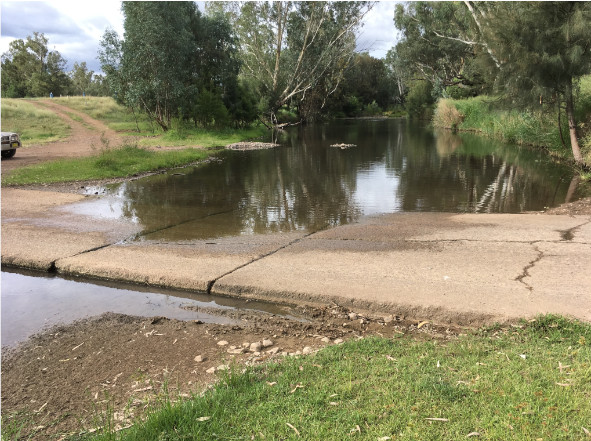

In [6]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_22_3_2018.jpg")

# Elfin Crossing 16.4.2018 

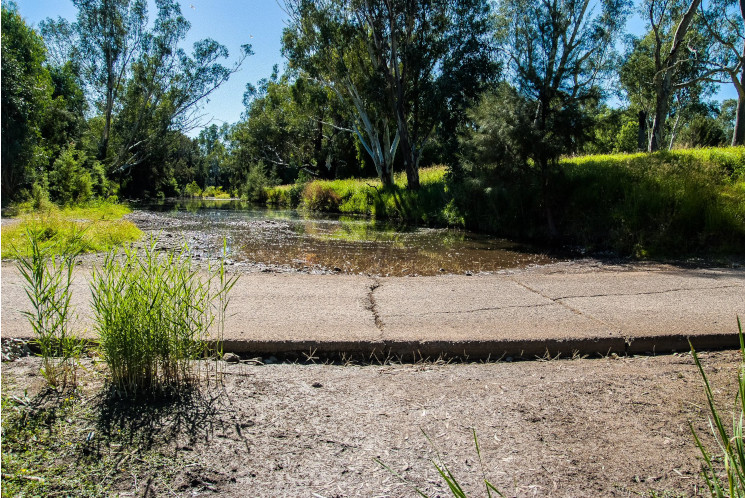

In [7]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_16_4_2018.jpg")

# Elfin Crossing 14.5.2018 

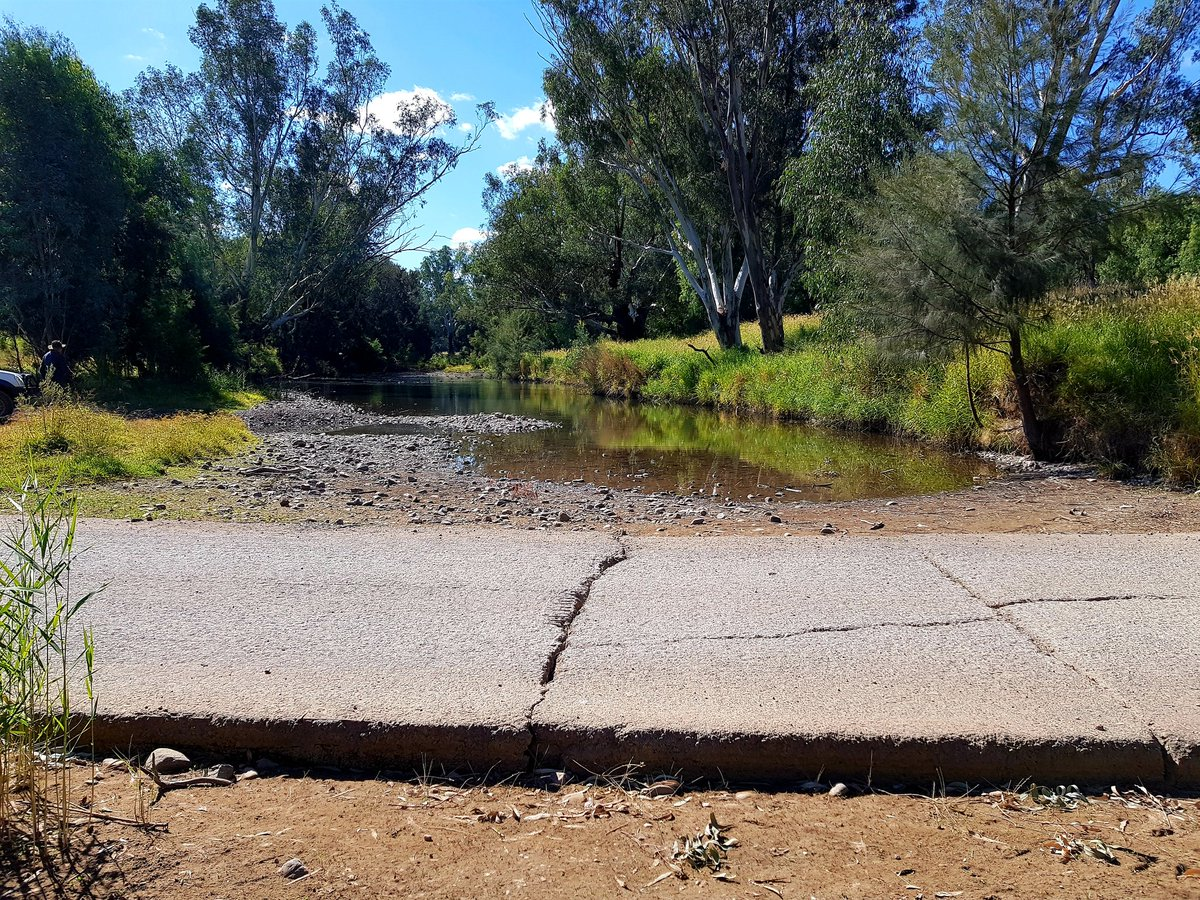

In [8]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_14_5_2018.jpg")

# Elfin Crossing 19.9.2018

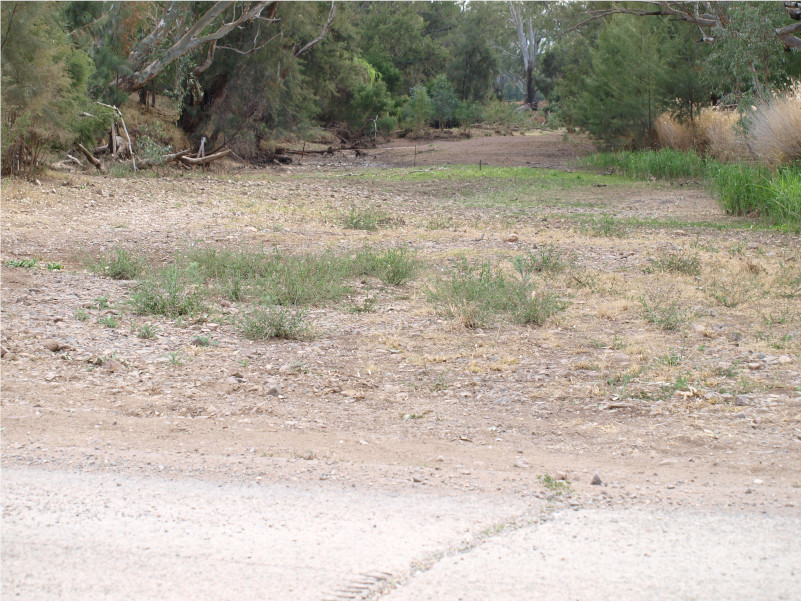

In [9]:
Image("/home/jovyan/work/visualisations/assets/Elfin_Crossing_19_9_2019.jpg")

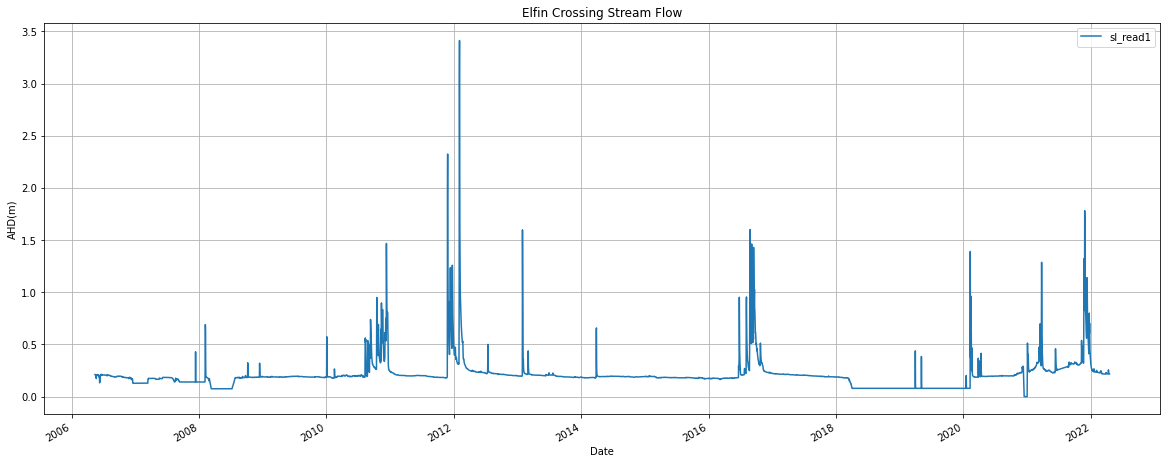

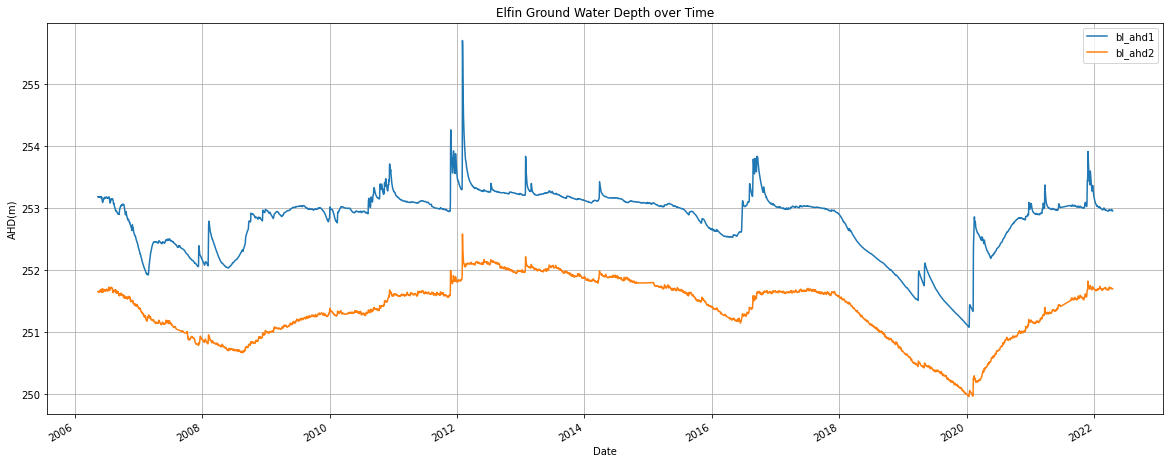

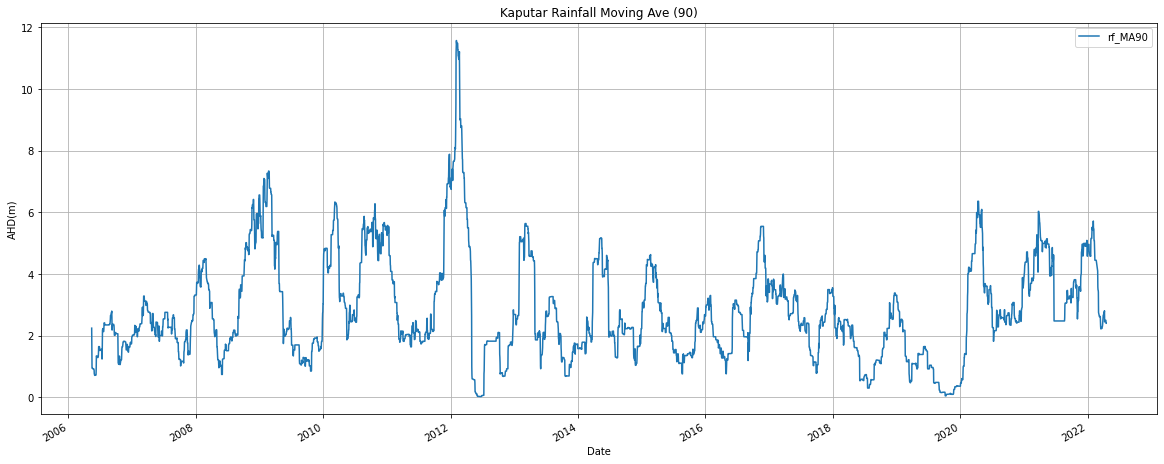

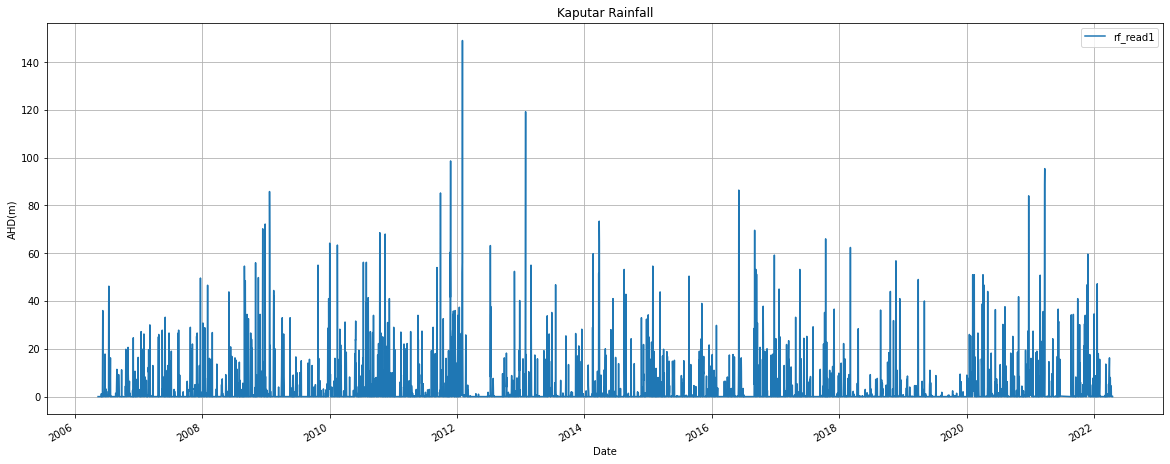

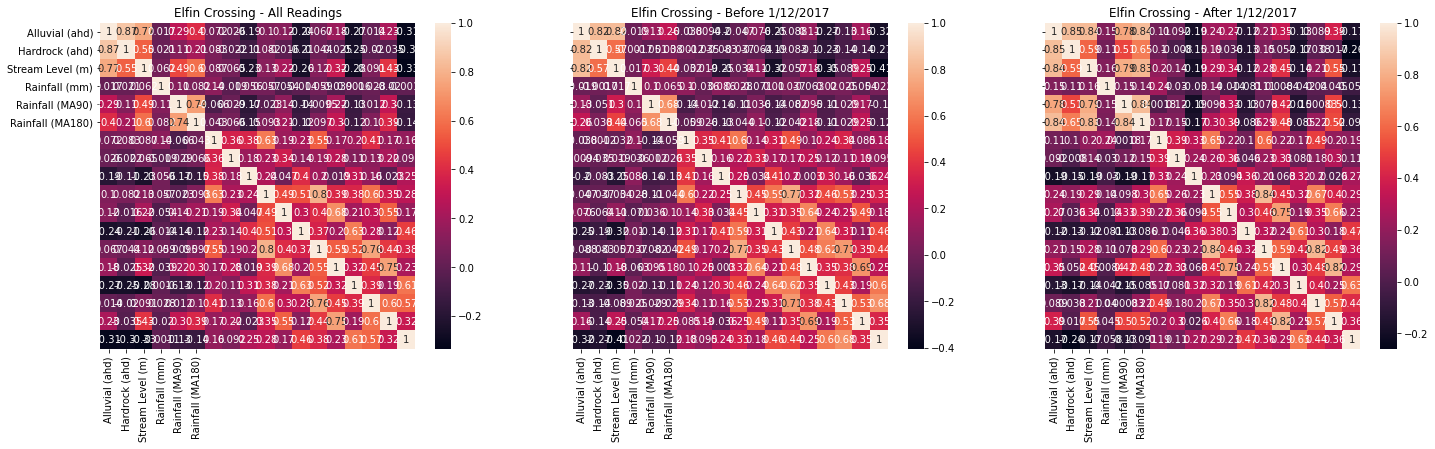

In [10]:
df1.plot(x='read_date', y='sl_read1',figsize=(20,8), grid=True, title='Elfin Crossing Stream Flow', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y=['bl_ahd1','bl_ahd2'],figsize=(20,8), grid=True, title='Elfin Ground Water Depth over Time', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y='rf_MA90',figsize=(20,8), grid=True, title='Kaputar Rainfall Moving Ave (90)', xlabel='Date',ylabel='AHD(m)')
df1.plot(x='read_date', y='rf_read1',figsize=(20,8), grid=True, title='Kaputar Rainfall', xlabel='Date',ylabel='AHD(m)')


df1_corr = df1.corr(method='spearman')

#filter out rows from the groundwater series start date
        
df3 = df1[df1['read_date'] < '2017-11-30']
df4 = df1[df1['read_date'] >= '2017-11-30']

df3_corr = df3.corr(method='spearman')


fig, ax = plt.subplots(1,3, sharey=True,figsize=(24, 6))
# fig.suptitle('Correllation Heatmaps', fontsize=20)
ax[0].set_title('Elfin Crossing - All Readings')
ax[1].set_title('Elfin Crossing - Before 1/12/2017')
ax[2].set_title('Elfin Crossing - After 1/12/2017')

df4_corr = df4.corr(method='spearman')

sns.heatmap(df1_corr, annot=True,ax=ax[0],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)'])
sns.heatmap(df3_corr, annot=True,ax=ax[1],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)'])
sns.heatmap(df4_corr, annot=True,ax=ax[2],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)', 'Rainfall (MA180)']);



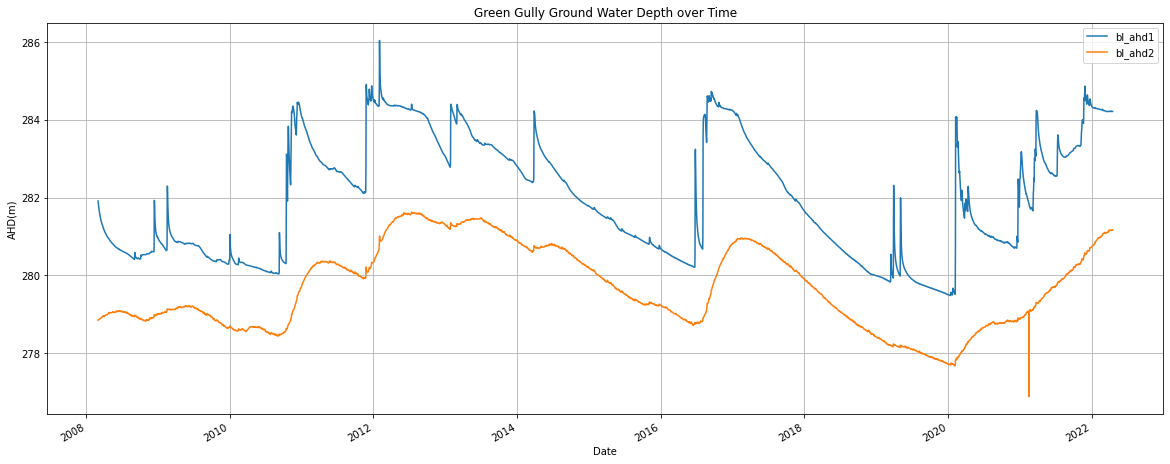

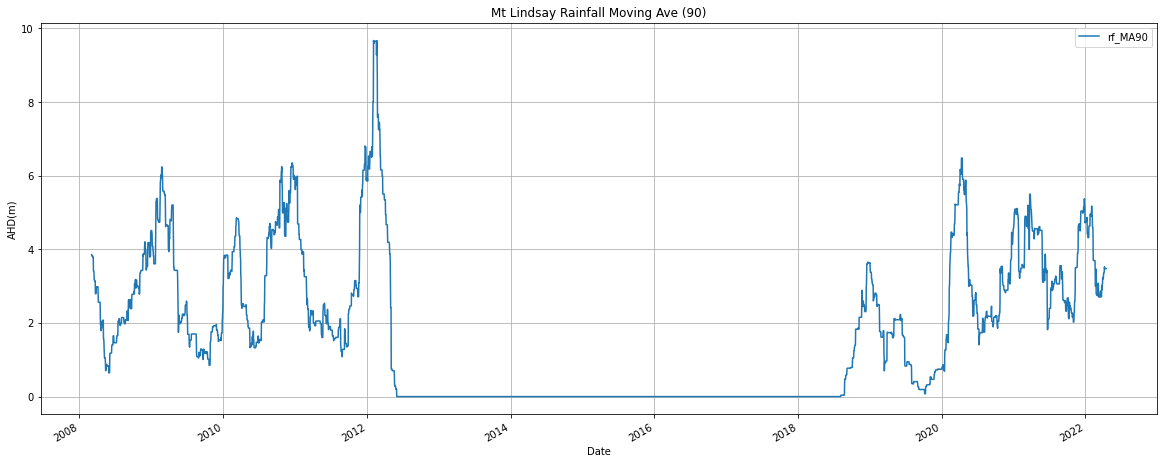

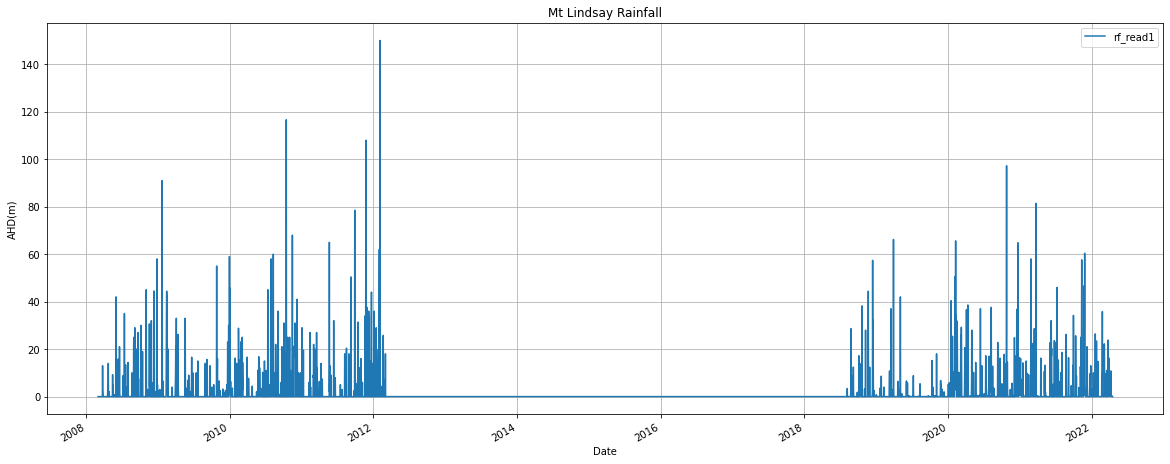

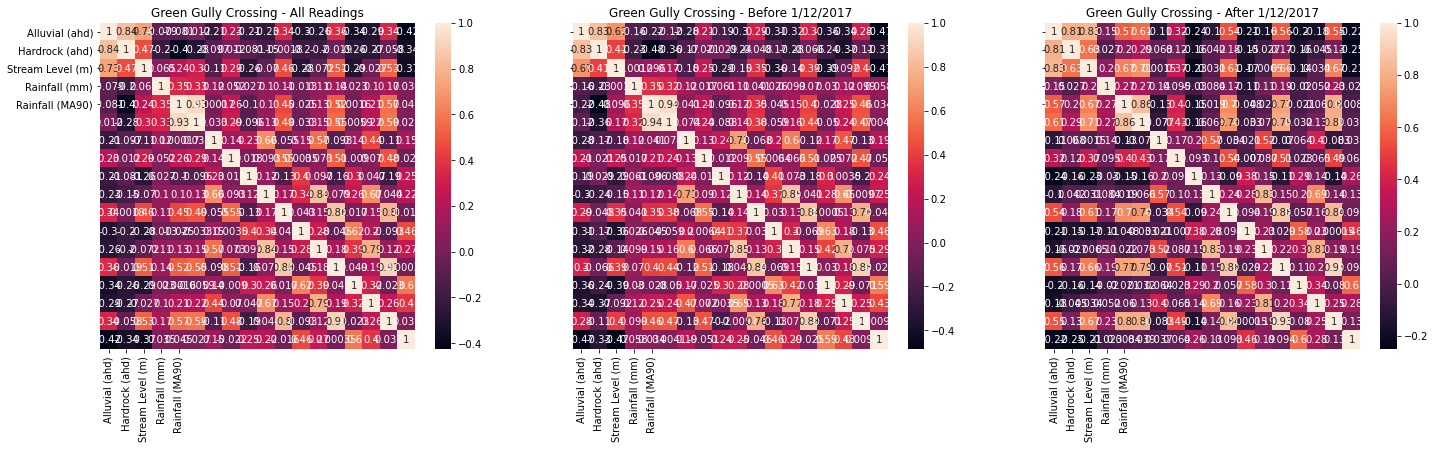

In [11]:
df2.plot(x='read_date', y=['bl_ahd1','bl_ahd2'],figsize=(20,8), grid=True, title='Green Gully Ground Water Depth over Time', xlabel='Date',ylabel='AHD(m)')
df2.plot(x='read_date', y='rf_MA90',figsize=(20,8), grid=True, title='Mt Lindsay Rainfall Moving Ave (90)', xlabel='Date',ylabel='AHD(m)')
df2.plot(x='read_date', y='rf_read1',figsize=(20,8), grid=True, title='Mt Lindsay Rainfall', xlabel='Date',ylabel='AHD(m)')



df2_corr = df2.corr(method='spearman')

#filter out rows from the groundwater series start date
        
df5 = df2[df2['read_date'] < '2017-11-30']
df6 = df2[df2['read_date'] >= '2017-11-30']

df5_corr = df5.corr(method='spearman')


fig, ax = plt.subplots(1,3, sharey=True,figsize=(24, 6))
# fig.suptitle('Correllation Heatmaps', fontsize=20)
ax[0].set_title('Green Gully Crossing - All Readings')
ax[1].set_title('Green Gully Crossing - Before 1/12/2017')
ax[2].set_title('Green Gully Crossing - After 1/12/2017')

df6_corr = df6.corr(method='spearman')

sns.heatmap(df2_corr, annot=True,ax=ax[0],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)'])
sns.heatmap(df5_corr, annot=True,ax=ax[1],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)'])
sns.heatmap(df6_corr, annot=True,ax=ax[2],xticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)'],yticklabels=['Alluvial (ahd)','Hardrock (ahd)','Stream Level (m)','Rainfall (mm)', 'Rainfall (MA90)']);






# Stop here for summary heatmap



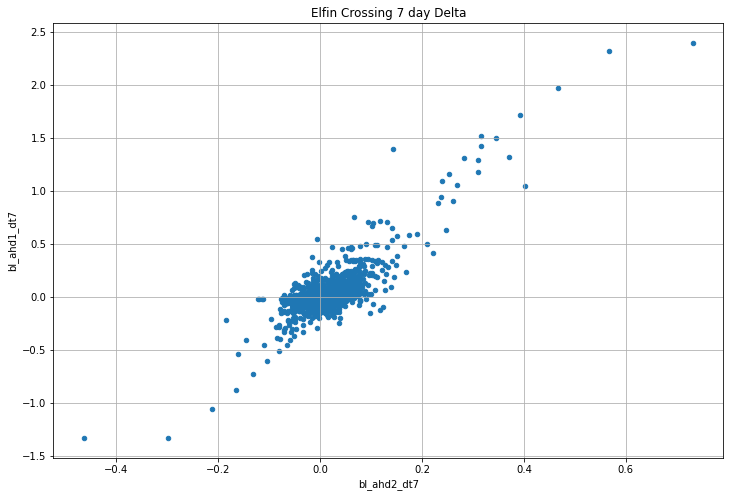

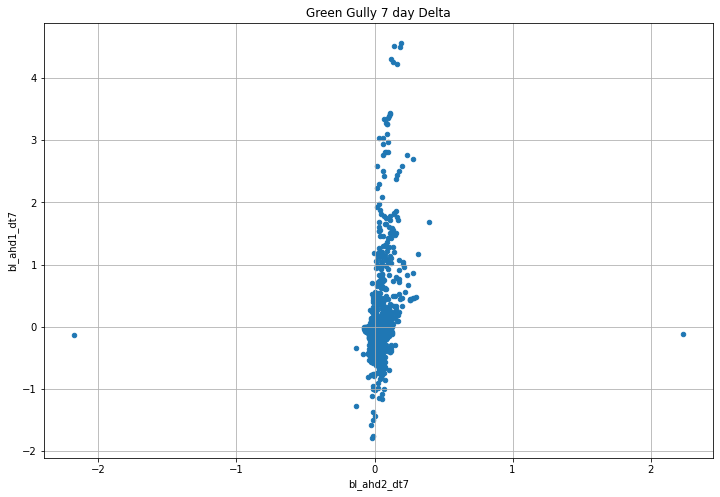

In [14]:
df1.plot.scatter(x='bl_ahd2_dt7', y='bl_ahd1_dt7', figsize=(12, 8), title="Elfin Crossing 7 day Delta", xlabel="GW967137.2.2", ylabel='GW967137.1.1',grid=True)
df2.plot.scatter(x='bl_ahd2_dt7', y='bl_ahd1_dt7', figsize=(12, 8), title="Green Gully 7 day Delta", xlabel='GW967138.2.2', ylabel='GW967138.1.1', grid=True)

plt.show()

In [15]:
df1.cov()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
bl_ahd1,0.266014,0.216963,0.041100,0.377225,0.370020,-0.000708,0.000038,-0.001848,-0.006565,0.000883,-0.007972,-0.010944,0.002650,-0.009612,-0.019972,0.006614,-0.013283
bl_ahd2,0.216963,0.243608,0.022164,0.117104,0.133178,-0.000397,-0.000089,-0.000338,-0.004084,-0.000680,-0.002756,-0.007789,-0.001163,-0.003800,-0.015764,-0.002538,-0.006006
sl_read1,0.041100,0.022164,0.020397,0.296098,0.105298,-0.000170,-0.000174,-0.002534,-0.003909,-0.000517,-0.009547,-0.005480,-0.000058,-0.010758,-0.007400,0.001251,-0.012720
rf_read1,0.377225,0.117104,0.296098,80.153475,2.309949,0.083869,0.008163,0.121743,0.069998,-0.012605,-0.123649,0.016327,-0.017691,-0.169357,-0.005954,-0.006162,-0.203777
rf_MA90,0.370020,0.133178,0.105298,2.309949,2.764475,-0.000474,0.000747,-0.002648,-0.009711,0.005746,-0.016826,-0.016979,0.013463,-0.023296,-0.028780,0.031938,-0.034264
bl_ahd1_dt1,-0.000708,-0.000397,-0.000170,0.083869,-0.000474,0.001421,0.000359,0.002023,0.001502,0.000184,0.000582,0.001270,0.000121,0.000381,0.001326,0.000184,0.000464
bl_ahd2_dt1,0.000038,-0.000089,-0.000174,0.008163,0.000747,0.000359,0.000176,0.000516,0.000532,0.000157,0.000398,0.000459,0.000148,0.000315,0.000471,0.000189,0.000345
sl_read1_dt1,-0.001848,-0.000338,-0.002534,0.121743,-0.002648,0.002023,0.000516,0.005071,0.002283,0.000320,0.002923,0.002028,0.000247,0.002679,0.002027,0.000289,0.002821
bl_ahd1_dt7,-0.006565,-0.004084,-0.003909,0.069998,-0.009711,0.001502,0.000532,0.002283,0.013038,0.003121,0.011839,0.010841,0.002241,0.005571,0.010566,0.002394,0.005506
bl_ahd2_dt7,0.000883,-0.000680,-0.000517,-0.012605,0.005746,0.000184,0.000157,0.000320,0.003121,0.001290,0.003240,0.002721,0.001088,0.001578,0.002511,0.001268,0.001494


In [16]:
df2.cov()

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
bl_ahd1,2.168083,1.276988,0.105519,0.679989,0.821069,-0.006653,0.002900,-0.004436,-0.061684,0.020677,-0.020361,-0.114568,0.041051,-0.025971,-0.212731,0.080627,-0.042212
bl_ahd2,1.276988,1.111307,0.030019,-0.026911,0.132906,-0.003406,-0.001079,-0.000461,-0.026280,-0.002162,-0.003829,-0.052125,-0.004231,-0.006318,-0.111473,-0.012824,-0.011576
sl_read1,0.105519,0.030019,0.022789,0.331285,0.115625,-0.000197,0.000185,-0.002832,-0.003443,0.001957,-0.010731,-0.005475,0.004543,-0.012095,-0.005367,0.010539,-0.014321
rf_read1,0.679989,-0.026911,0.331285,84.948222,2.503219,0.231886,0.005347,0.131437,0.259364,0.007421,-0.138799,0.161540,0.022117,-0.190518,0.120030,0.097911,-0.229838
rf_MA90,0.821069,0.132906,0.115625,2.503219,3.010890,0.002127,0.004063,-0.003000,0.000588,0.029956,-0.018814,0.004006,0.062080,-0.026121,0.016474,0.134736,-0.038751
bl_ahd1_dt1,-0.006653,-0.003406,-0.000197,0.231886,0.002127,0.013374,0.000435,0.004648,0.014571,0.000388,0.001444,0.013482,0.000465,0.000847,0.012297,0.001178,0.001413
bl_ahd2_dt1,0.002900,-0.001079,0.000185,0.005347,0.004063,0.000435,0.002063,0.000276,0.000799,0.001199,0.000252,0.000707,0.001335,0.000162,0.000583,0.001647,0.000152
sl_read1_dt1,-0.004436,-0.000461,-0.002832,0.131437,-0.003000,0.004648,0.000276,0.005666,0.004744,0.000124,0.003271,0.004691,0.000073,0.002996,0.004432,0.000117,0.003157
bl_ahd1_dt7,-0.061684,-0.026280,-0.003443,0.259364,0.000588,0.014571,0.000799,0.004744,0.124047,0.005174,0.023895,0.115480,0.005488,0.009195,0.102867,0.009713,0.011344
bl_ahd2_dt7,0.020677,-0.002162,0.001957,0.007421,0.029956,0.000388,0.001199,0.000124,0.005174,0.003647,0.001862,0.004875,0.003530,0.000568,0.004327,0.005689,0.000165


In [17]:
df1_corr = df1.corr(method='spearman')

In [18]:
df1_corr

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
bl_ahd1,1.000000,0.870390,0.787259,0.009168,0.284944,0.088271,0.029283,-0.181234,0.115026,0.128472,-0.237197,0.087240,0.184543,-0.253843,0.031834,0.240672,-0.305472
bl_ahd2,0.870390,1.000000,0.554984,0.015306,0.100569,0.094637,-0.021191,-0.102763,0.092229,-0.017503,-0.205988,0.057416,-0.026202,-0.244143,-0.007115,-0.036399,-0.296346
sl_read1,0.787259,0.554984,1.000000,0.050505,0.469611,0.109308,0.067906,-0.218564,0.143885,0.225973,-0.255048,0.136621,0.323546,-0.274986,0.104823,0.423046,-0.341379
rf_read1,0.009168,0.015306,0.050505,1.000000,0.110602,0.129258,-0.027215,0.055981,0.058918,-0.052196,-0.008007,0.062609,-0.040241,0.008129,0.032414,-0.022888,0.001929
rf_MA90,0.284944,0.100569,0.469611,0.110602,1.000000,-0.049106,0.032182,-0.160511,-0.005997,0.142597,-0.132041,0.009912,0.217583,-0.110779,0.028336,0.300499,-0.112243
bl_ahd1_dt1,0.088271,0.094637,0.109308,0.129258,-0.049106,1.000000,0.348524,0.359462,0.637002,0.186558,0.239617,0.545133,0.169159,0.192500,0.407602,0.171085,0.146387
bl_ahd2_dt1,0.029283,-0.021191,0.067906,-0.027215,0.032182,0.348524,1.000000,0.169465,0.228401,0.342016,0.145939,0.181907,0.274530,0.109478,0.132455,0.223010,0.091370
sl_read1_dt1,-0.181234,-0.102763,-0.218564,0.055981,-0.160511,0.359462,0.169465,1.000000,0.229942,0.039158,0.402823,0.180970,0.009101,0.292098,0.144142,-0.027654,0.240319
bl_ahd1_dt7,0.115026,0.092229,0.143885,0.058918,-0.005997,0.637002,0.228401,0.229942,1.000000,0.481491,0.500586,0.808031,0.387263,0.381279,0.597494,0.344570,0.273141
bl_ahd2_dt7,0.128472,-0.017503,0.225973,-0.052196,0.142597,0.186558,0.342016,0.039158,0.481491,1.000000,0.291328,0.404784,0.686778,0.218860,0.305917,0.554693,0.171733


<AxesSubplot:title={'center':'Elfin Crossing Correllation Heatmap'}>

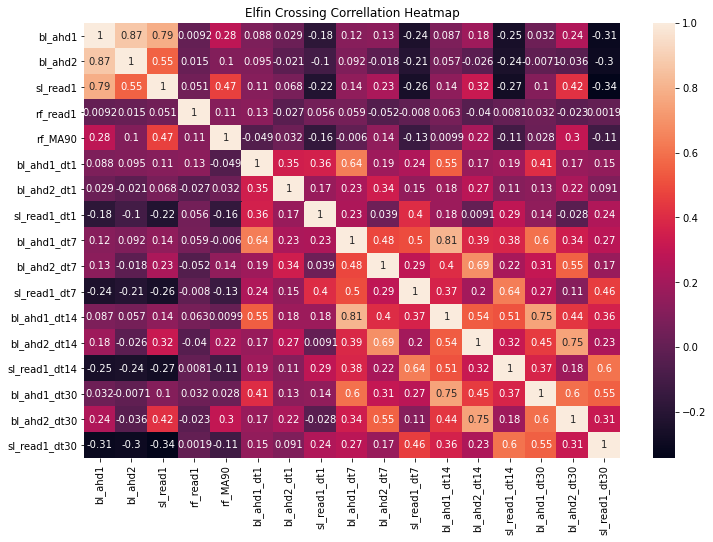

In [19]:
plt.figure(figsize=(12, 8))
plt.title("Elfin Crossing Correllation Heatmap")
sns.heatmap(df1_corr,annot=True)

In [20]:
df2_corr = df2.corr(method='spearman')

df2_corr

,bl_ahd1,bl_ahd2,sl_read1,rf_read1,rf_MA90,bl_ahd1_dt1,bl_ahd2_dt1,sl_read1_dt1,bl_ahd1_dt7,bl_ahd2_dt7,sl_read1_dt7,bl_ahd1_dt14,bl_ahd2_dt14,sl_read1_dt14,bl_ahd1_dt30,bl_ahd2_dt30,sl_read1_dt30
bl_ahd1,1.000000,0.832877,0.707110,0.014501,0.299311,-0.261215,0.199574,-0.194734,-0.308608,0.284381,-0.295772,-0.338710,0.289303,-0.339715,-0.369415,0.263463,-0.431549
bl_ahd2,0.832877,1.000000,0.463101,-0.010710,0.045160,-0.118340,-0.012276,-0.067682,-0.190119,-0.048966,-0.189405,-0.232310,-0.076416,-0.251499,-0.299671,-0.122209,-0.340248
sl_read1,0.707110,0.463101,1.000000,0.059119,0.478984,-0.138792,0.259836,-0.235792,-0.127882,0.398639,-0.267513,-0.126295,0.437110,-0.292150,-0.093788,0.445420,-0.369298
rf_read1,0.014501,-0.010710,0.059119,1.000000,0.118290,0.128005,-0.033859,0.052961,0.058854,-0.025963,-0.013598,0.043653,-0.014163,-0.003705,0.005249,0.013959,-0.011855
rf_MA90,0.299311,0.045160,0.478984,0.118290,1.000000,-0.177266,0.234287,-0.176846,-0.131090,0.398991,-0.152734,-0.107361,0.451809,-0.134092,-0.030698,0.496947,-0.131084
bl_ahd1_dt1,-0.261215,-0.118340,-0.138792,0.128005,-0.177266,1.000000,0.113970,0.221277,0.667379,-0.089140,0.154760,0.551724,-0.142274,0.134471,0.419630,-0.154273,0.145731
bl_ahd2_dt1,0.199574,-0.012276,0.259836,-0.033859,0.234287,0.113970,1.000000,0.021289,0.067080,0.540681,0.017679,0.045746,0.497140,0.002100,0.040890,0.464073,-0.013805
sl_read1_dt1,-0.194734,-0.067682,-0.235792,0.052961,-0.176846,0.221277,0.021289,1.000000,0.135855,-0.115137,0.401942,0.102181,-0.145211,0.297660,0.060018,-0.164221,0.242223
bl_ahd1_dt7,-0.308608,-0.190119,-0.127882,0.058854,-0.131090,0.667379,0.067080,0.135855,1.000000,0.125720,0.356808,0.835635,0.028165,0.274084,0.648837,-0.012682,0.239733
bl_ahd2_dt7,0.284381,-0.048966,0.398639,-0.025963,0.398991,-0.089140,0.540681,-0.115137,0.125720,1.000000,0.059266,0.103304,0.849850,0.035518,0.095923,0.780355,0.004663


<AxesSubplot:title={'center':'Green Gully Correllation Heatmap'}>

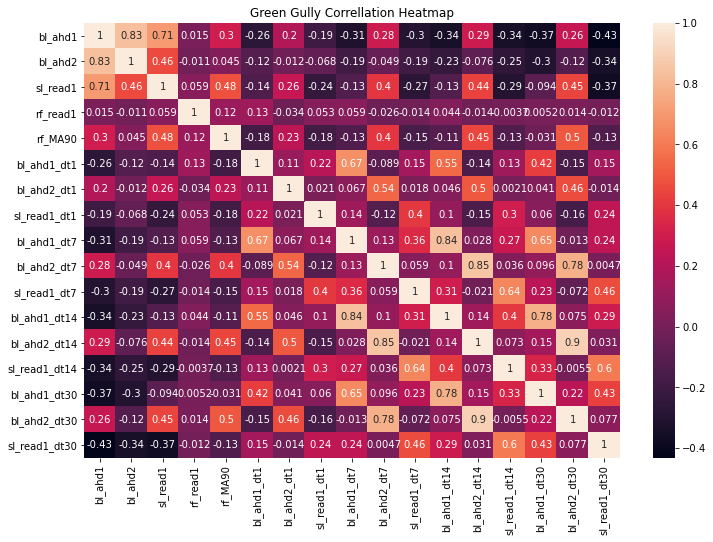

In [21]:


plt.figure(figsize=(12, 8))
plt.title("Green Gully Correllation Heatmap")
sns.heatmap(df2_corr, annot=True)

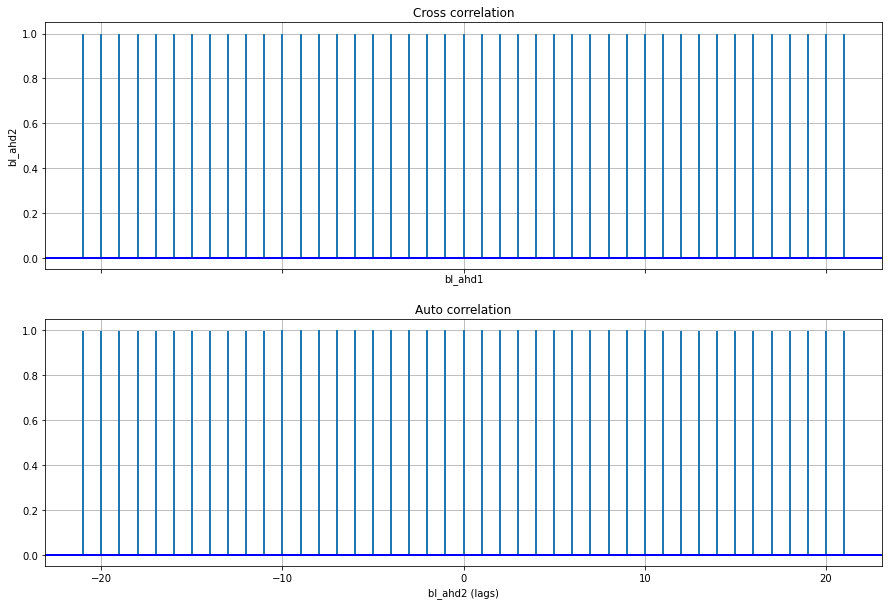

In [62]:
# https://www.geeksforgeeks.org/matplotlib-pyplot-xcorr-in-python/
# cross correlation functions measures the strength of the relationship between the relative movements of two variables

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(15, 10))
ax1.set_ylabel('bl_ahd2')
ax1.set_xlabel('bl_ahd1')
ax1.set_title('Cross correlation')
ax1.xcorr(df2['bl_ahd1'], df2['bl_ahd2'], usevlines=True, maxlags=21, normed=True, lw=2)
ax1.axhline(0, color='blue', lw=2)
ax1.grid(True)

# autocorrelation measures a set of current values against past values to see if they correlate

ax2.set_xlabel('bl_ahd2 (lags)')
ax2.set_title('Auto correlation')
ax2.acorr(df2['bl_ahd2'], usevlines=True, normed=True, maxlags=21, lw=2)
ax2.axhline(0, color='blue', lw=2)
ax2.grid(True)

plt.show()


In [60]:
import scipy.signal as signal
def xcorr(x,y):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    return lags, corr


x = df1['bl_ahd1'] 
y = df1['bl_ahd2']
lags,c = xcorr(x,y);
plt.figure()
plt.stem(lags,c)
plt.show()


AttributeError: module 'scipy.signal' has no attribute 'correlation_lags'